# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
PATH_TO_ENV = "Tennis_Linux/Tennis.x86"
BRAIN = "TennisBrain"
TRAINING = True

env = UnityEnvironment(file_name=PATH_TO_ENV, no_graphics=TRAINING)

#ACTION_SIZE = env.brains[BRAIN].vector_action_space_size
#STATE_SIZE = env.brains[BRAIN].vector_observation_space_size ### ???

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
env.brains[BRAIN].vector_action_space_size

2

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=TRAINING)[BRAIN]

# number of agents 
NUM_AGENTS = len(env_info.agents)
print('Number of agents:', NUM_AGENTS)

# size of each action
ACTION_SIZE = env.brains[BRAIN].vector_action_space_size
print('Size of each action:', ACTION_SIZE)

# examine the state space 
states = env_info.vector_observations
STATE_SIZE = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], STATE_SIZE))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

# Convenience functions

In [5]:
def act(env, actions, brain_name=BRAIN) -> tuple:
    """Sends actions to the environment env and observes the results.
    Returns a tuple of rewards, next_states, dones (One per agent)"""
    action_result = env.step(actions)[brain_name] # Act on the environment and observe the result
    return (action_result.rewards,
            action_result.vector_observations, # next states
            action_result.local_done) # True if the episode ended
    
def reset(env, training=TRAINING, brain_name=BRAIN) -> np.ndarray:
    """Syntactic sugar for resetting the unity environment"""
    return env.reset(train_mode=training)[brain_name].vector_observations

# Prepare the training

In [6]:
#from IPython.display import clear_output
np.set_printoptions(precision=3, suppress=True)

In [7]:
# Profiling (optional)
import cProfile
profiling = False # Set to True to profile execution time
if profiling:
    profile = cProfile.Profile()

In [8]:
# Invite our agent & import utils
from ddpg_agent import Agent
from buffer import ReplayBuffer
from ounoise import OUNoise
import torch
import random
# Params
SEED = random.randint(0, 1e6)
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256
USE_CUDA = True

# Initialize components
random.seed(SEED)
torch.manual_seed(SEED)

In [9]:
def train(agents, env, num_episodes, log_freq, max_t=20000, profiling=False, profiler=None):        
    score_hist = []
    if profiling: 
        profile.enable()
    
    # Train
    for i in range(num_episodes):
        states = reset(env)
        scores = np.zeros(NUM_AGENTS)
        if i > 0:
            ounoise.decay_step()
            
        for j in range(max_t): # Safer than while not np.any(dones)           
            # Generate action noise
            noise = ounoise.sample()
            
            # Each agent decides its action based on its own observation
            assert len(noise) == len(states) & len(noise) == len(agents), 'size mismatch'
            actions = np.vstack([agent.decide(np.expand_dims(state, 0)) + ns 
                               for agent, state, ns in zip(agents, states, noise)])
                
            # Send the actions to the environment
            rewards, next_states, dones = act(env, actions)     
            scores += rewards
            
            # Save to buffer
            buffer.add(states, actions, rewards, next_states, dones)
            
            # Note: The agents' critics learn from the global state, not only the individual observations
            # Update only after collecting enough experiences
            if len(buffer) >= BATCH_SIZE:
                for agent_number, agent in enumerate(agents):
                    # Sample experiences separately for each agent's critic
                    experiences = buffer.sample(BATCH_SIZE, NUM_AGENTS) #(states, actions, rewards, next_states, dones)
                    
                    # To update one agent, for each sampled experience we need...
                    # ...All the actions that the (updated) target actors would take observing the resulting state
                    assert len(experiences[3]) == len(agents), 'size mismatch' # experiences[3]: next_states
                    next_actions = torch.cat([a.decide(s, use_target=True, as_tensor=True) 
                                              for a, s in zip(agents, experiences[3])], dim=1) 

                    # ...All the actions that the (updated) local actors would take observing the current state
                    assert len(experiences[0]) == len(agents), 'size mismatch' # experiences[0]: states
                    current_actions = torch.cat([a.decide(s, use_target=False, as_tensor=True) 
                                              for a, s in zip(agents, experiences[0])], dim=1) 
                    
                    # Finally apply the update
                    agent.learn(experiences, next_actions, current_actions, agent_number)
                
            # Step
            states = next_states # roll over states to next time step
            if np.any(dones): # exit loop if episode finished
                break 
                
        # Logging
        score_hist.append(max(scores))
        if (i % log_freq == 0) and (i > 0):
            print(f'Avg. score episodes {i-log_freq}-{i}: {np.mean(score_hist[-log_freq:])}')
        
        if np.mean(score_hist[-100:]) >= .5:
            print(f'Solved in {i} steps!')
            break

    if profiling: 
        profile.disable()
        
    return np.array(score_hist)

In [10]:
%%time
buffer = ReplayBuffer(BUFFER_SIZE, USE_CUDA)
ounoise = OUNoise(NUM_AGENTS, mu=.0, theta=1, sigma=.15, decay_rate=.95)
agents = [Agent(STATE_SIZE, ACTION_SIZE, NUM_AGENTS, USE_CUDA) for agent in ('Alice', 'Bob')]

score_hist = train(agents, env, num_episodes=30, log_freq=3)

Avg. score episodes 0-3: 0.033333333830038704
Avg. score episodes 3-6: 0.0
Avg. score episodes 6-9: 0.0
Avg. score episodes 9-12: 0.0
Avg. score episodes 12-15: 0.0
Avg. score episodes 15-18: 0.0
Avg. score episodes 18-21: 0.0
Avg. score episodes 21-24: 0.0
Avg. score episodes 24-27: 0.0
CPU times: user 6.75 s, sys: 584 ms, total: 7.33 s
Wall time: 7.85 s


In [11]:
#### Old viz
#for i in range(1, 20):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[BRAIN]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[BRAIN]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [12]:
env.close()

# Plotting + visualizing

In [13]:
from matplotlib import pyplot as plt
#import seaborn as sns

In [14]:
def moving_average(signal:np.ndarray , period: int):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return np.array(buffer)

#def moving_std(signal:np.ndarray , period: int):
#    buffer = [np.nan] * period
#    for i in range(period,len(signal)):
#        buffer.append(signal[i-period:i].std())
#    return np.array(buffer)

(0, 300)

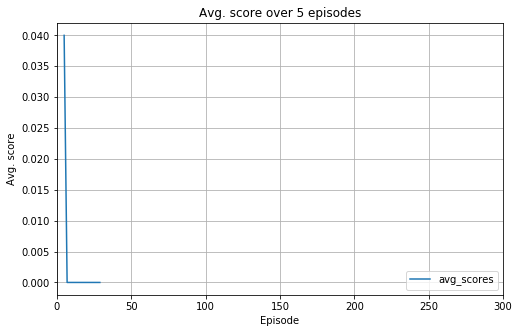

In [15]:
length = 5
avg_scores = moving_average(score_hist, length)
plt.figure(figsize=(8,5))
plt.plot(avg_scores, label='avg_scores')
#plt.hlines(30, xmin=0, xmax=300, colors='r', label='solved')
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Avg. score')
plt.title(f'Avg. score over {length} episodes')
plt.legend(loc='lower right')
plt.xlim((0, 300))

# Save models

In [16]:
from datetime import datetime
def save_agents(agents, score_hist, file_name=None, avg_scores=None):
    """Saves the agents' scores and the underlying pytorch model"""
    checkpoint = {'score_hist': score_hist}
    
    for name, agent in zip(('Alice', 'Bob'), agents):
        checkpoint[f'{name}_actor_state_dict'] = agent.actor_local.state_dict()
        checkpoint[f'{name}_critic_state_dict'] = agent.critic_local.state_dict()
        
    if not file_name:
        # Standard name: date-episodes-score
        file_name = f'{datetime.strftime(datetime.now(),"%y-%m-%d_%H.%M")}-{len(avg_scores)}-{round(avg_scores[-1],1)}'
        
    torch.save(checkpoint, f'models/{file_name}.pth')

In [17]:
save_agents(agents, score_hist, avg_scores=avg_scores)